<a href="https://colab.research.google.com/github/Max280201/TrafficSignCV/blob/main/TrafficSignRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Sign Recognition

## 1 Introduction

This notebook is part of our work on the topic **_Traffic Sign Detection and Recognition_** for the module *Integration Seminar* in course *WWI20DSB* supervised by Prof. Dr. Bernhard Drabant at the Baden-Wuerttemberg Cooperative State University Mannheim. 

Team Members:
- Max Bernauer (5763624)
- Philipp Dingfelder (8687786)
- Valentin Moritz Müller (4616344)

Due to the extent of the project, technical reasons like the usage of different deep learning frameworks, and because of the nature of the task and the data sets used, two models will be implemented for the task in two separate notebooks.

This notebook focuses on the *Recognition* part of the task in form of an image classification task. The data set [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) is used. The model is implemented with the deep learning library *TensorFlow* and its architecture is derived from VGG16, but simplyfied due to the relatively small size of the images.

The *Detection* part is implemented with a *YOLOv7*-model with the framework *PyTorch* in the notebook [TrafficSignDetection.ipynb](https://colab.research.google.com/drive/1gWcz8Afu61OSc1n4cyP5Gfw0-cIVyuT6?usp=sharing). It uses the data set [GTSDB - German Traffic Sign Detection Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign).



## 2 Setup

### 2.1 Imports

In [ ]:
from google.colab import drive

import matplotlib.pyplot as plt

import glob
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import cv2

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model


tf.__version__

'2.9.2'

### 2.2 Configuration

In [ ]:
sns.set_style('darkgrid')

drive.mount('/content/drive')

Mounted at /content/drive


### 2.3 Import Data

* prerequisite: personal access token for kaggle is stored in an kaggle.json file in either the root dir of this runtime enviromnemt or in google drive
* will download the dataset and store it unzipped it in the content dir
* will lead to following directories for the GTSRB data set
    * train: `/content/Train/`
    * test:  `/content/`

Setting up kaggle for this environment:

In [ ]:
! pip install kaggle
! mkdir -p ~/.kaggle/
# for the case, that kaggle.json is stored in the drive
! cp drive/MyDrive/kaggle.json ~/.kaggle/
# for the case, if kaggle.json is stored under the root dir
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'drive/MyDrive/kaggle.json': No such file or directory


Downloading and unpacking the data set:

In [ ]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
! unzip -n -q gtsrb-german-traffic-sign.zip -d GTSRB

 98% 597M/612M [00:02<00:00, 269MB/s]
100% 612M/612M [00:02<00:00, 261MB/s]


The following code removes unnecessary files to save space, and the `kaggle.json` to avoid re-download. Only works if `kaggle.json` was uploaded and not copied from drive.

In [ ]:
! rm kaggle.json
! rm ~/.kaggle/kaggle.json
! rm gtsrb-german-traffic-sign.zip

## 3 Data Preparation

### 3.1 Input

First, some variables for the directory and for the data are created. The image sizes and channels are required for resizing and can also be used later in the construction of the neural network.

In [ ]:
data_dir = '/content/GTSRB/'
train_dir = data_dir + 'Train/'
test_dir = data_dir + 'Test/'

In [ ]:
NUM_CLASSES = len(os.listdir(train_dir))

BATCH_SIZE = 64

IMG_HEIGHT = 30
IMG_WIDTH = 30
CHANNELS = 3

A dictionary containing the full names for the labels is created. It is required for mapping the class numbers into a way more easily understandable for humans, for example in visualizations or for the final predictions.

In [ ]:
# Label Overview
class_names = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)',
    7:'Speed limit (100km/h)',
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop',
    15:'No vehicles',
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry',
    18:'General caution',
    19:'Dangerous curve left',
    20:'Dangerous curve right',
    21:'Double curve',
    22:'Bumpy road',
    23:'Slippery road',
    24:'Road narrows on the right',
    25:'Road work',
    26:'Traffic signals',
    27:'Pedestrians',
    28:'Children crossing',
    29:'Bicycles crossing',
    30:'Beware of ice/snow',
    31:'Wild animals crossing',
    32:'End speed + passing limits',
    33:'Turn right ahead', 
    34:'Turn left ahead',
    35:'Ahead only',
    36:'Go straight or right',
    37:'Go straight or left',
    38:'Keep right',
    39:'Keep left', 
    40:'Roundabout mandatory',
    41:'End of no passing',
    42:'End no passing veh > 3.5 tons', 
}

Next, the training data is read from the respective directory. In this case, the folder serves as the label and can be read as such.

The color needs to be transformed from BGR to RGB, and all images are resized to 30 x 30.

In [ ]:
# load data from train directory
train_images = []
train_labels = []

for i in range(NUM_CLASSES):
    path = train_dir + str(i) + '/'
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + img)
            imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_fromarray = Image.fromarray(imageRGB, 'RGB')
            resize_image = image_fromarray.resize((IMG_WIDTH, IMG_HEIGHT))
            train_images.append(np.array(resize_image))
            train_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print(train_images.shape, train_labels.shape)

(39209, 30, 30, 3) (39209,)


This is different for the testing data, which is all contained in the same folder. Thus, the labels need to be extracted from the csv located in the base folder. The path is taken from the csv, which consists of file name and test folder, so the base- instead of the train directory serves as base on which it has to be appended.

In [ ]:
from csv import Error
# load test data
test = pd.read_csv(data_dir + 'Test.csv')

test_labels = test['ClassId'].values
image_names = test['Path'].values

test_images = []

for img in image_names:
    try:
        image = cv2.imread(data_dir + img)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_fromarray = Image.fromarray(image_rgb, 'RGB')
        resized_image = image_fromarray.resize((IMG_WIDTH, IMG_HEIGHT))
        test_images.append(np.array(resized_image))
    except:
        print('Error in ' + img)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print(test_images.shape, test_labels.shape)

(12630, 30, 30, 3) (12630,)


### 3.2 Train-Test-Validation Split

Next, the training data is split into training and validation set with functions provided by scikit-learn.

In [ ]:
# split train dataset to training and validation
X_train, X_val, y_train, y_val = train_test_split(train_images, 
                                                  train_labels,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  shuffle=True)

The testing data is only shuffled.

In [ ]:
# shuffle testing data randomly
shuffle_indexes = np.arange(train_images.shape[0])
np.random.shuffle(shuffle_indexes)

X_test = train_images[shuffle_indexes]
y_test = train_labels[shuffle_indexes]

### 3.3 Data Exploration



Now, the training data is checked regarding the distribution of the classes.

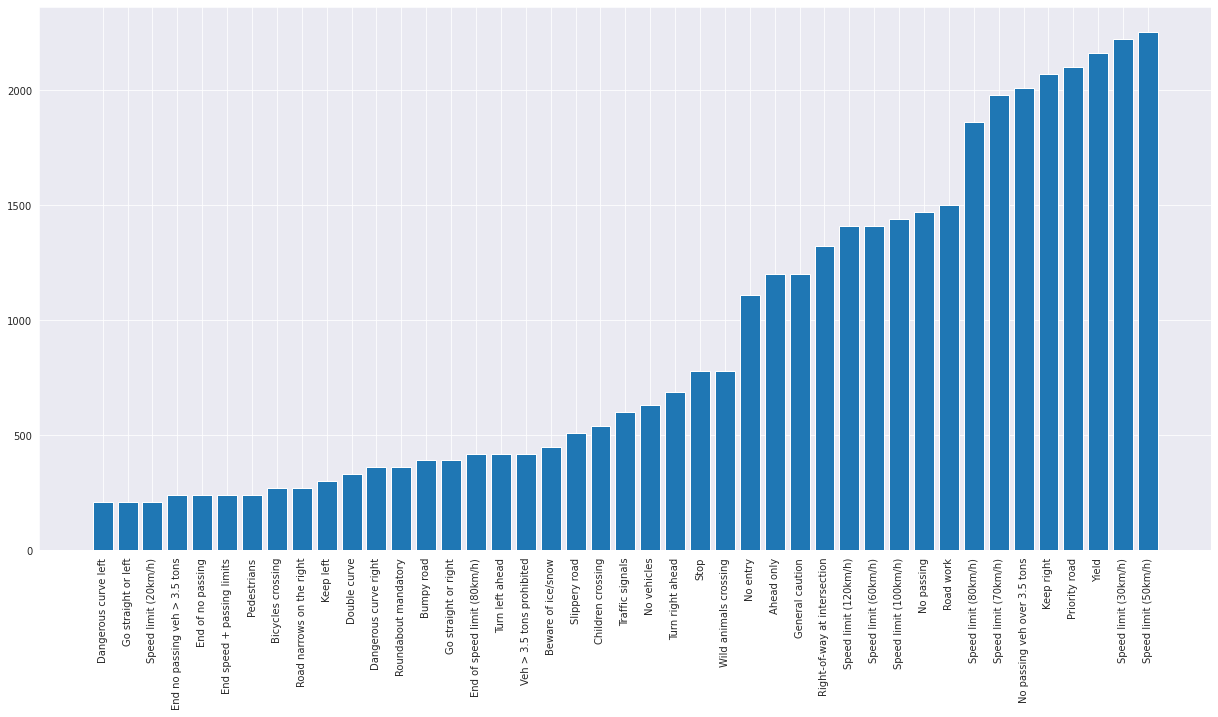

In [ ]:
folders = os.listdir(train_dir)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(class_names[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

As the plot shows, the data is somewhat imbalanced, and the fraction of speed limit signs in different forms is especially high.

The next plot visualizes some resized images with their respective labels.

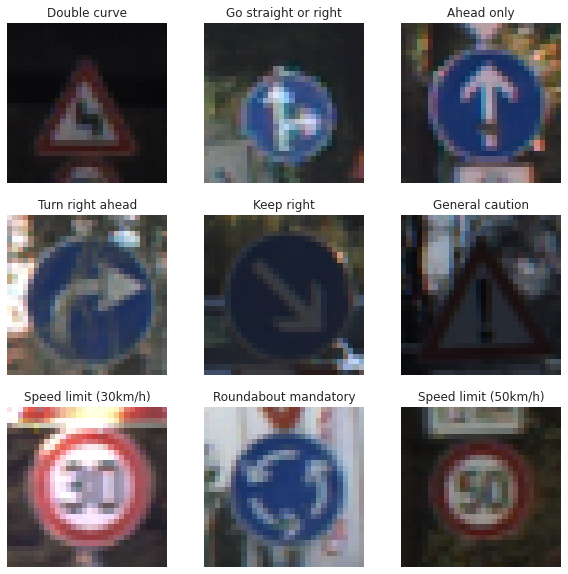

In [ ]:
# class_numbers = np.unique(image_labels)
plt.figure(figsize=(10, 10))
for counter in range(9):
  ax = plt.subplot(3, 3, counter + 1)
  plt.imshow(X_train[counter].astype("uint8"))
  plt.title(class_names[y_train[counter]])
  plt.axis("off")


## 4 Model Implementation

### 4.1 Model Definition

Now, a model is defined.

First, several layers are used as preprocessing layers, which increase the available amount of data by rotating, zooming, croping and translating the images. Horizontal- or vertical flipping is left out on purpose, because it is unlikely to occur for most and will even change the meaning of some traffic signs, like turn right/left ahead.

The next part of the model follows a simplified version of the VGG-16 architecture. The simplification is necessary to avoid overfitting the pictures, who are have a relatively low complexity with their size of 30 x 30. Furthermore, the simpler and thus smaller model is able to make predictions faster, which may be necessary in a time-critical context like autonomous driving.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)),
  # preprocessing layer: will be ignored during testing/ prod
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
  layers.RandomCrop(IMG_WIDTH - 2, IMG_HEIGHT - 2),
  layers.RandomTranslation(0.1, 0.1),
  # processing layer
  layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(padding='same'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(padding='same'),
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(padding='same'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 30, 30, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 30, 30, 3)         0         
                                                                 
 random_crop (RandomCrop)    (None, 28, 28, 3)         0         
                                                                 
 random_translation (RandomT  (None, 28, 28, 3)        0         
 ranslation)                                                     
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1

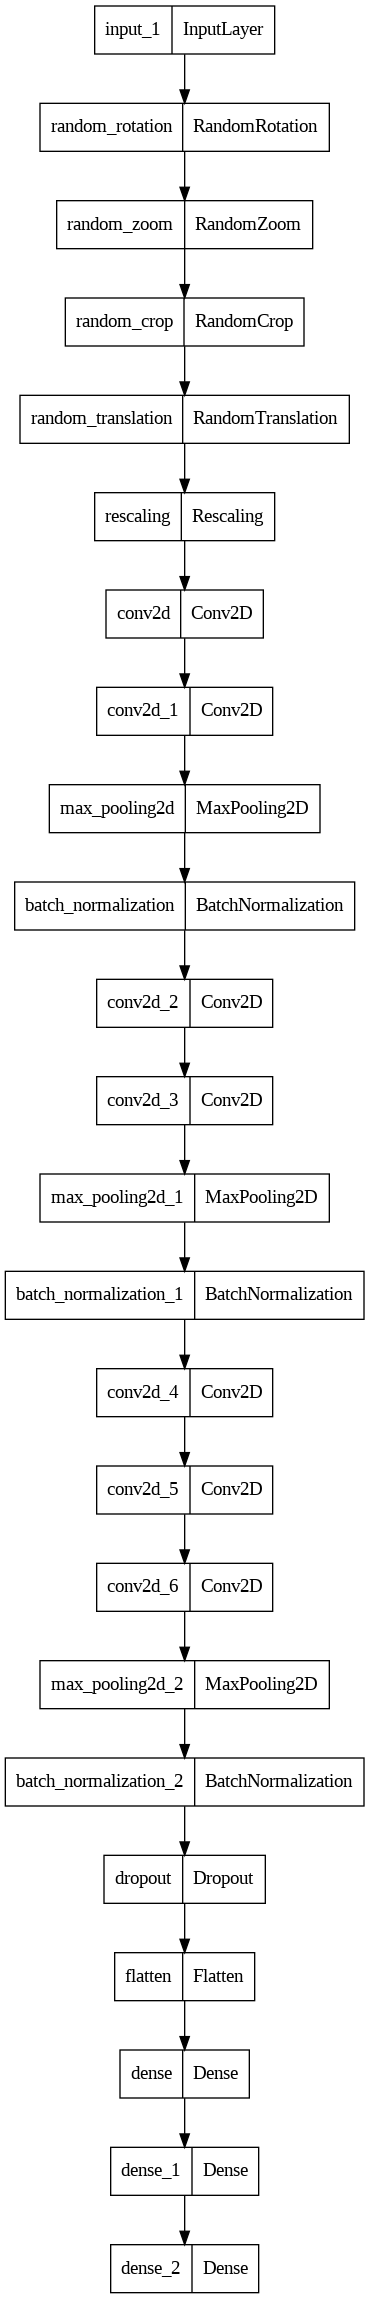

In [ ]:
plot_model(model)

### 4.2 Model Training

The model is trained for 100 epochs, with early stopping monitoring the loss on the validation set to avoid overfitting or needlessly long training times.

In [ ]:
epochs=100

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  verbose=2,
                                                  restore_best_weights=True)
    
history = model.fit(
  X_train, y_train, 
  validation_data=(X_val, y_val),
  epochs=epochs,
  callbacks=early_stopping
)

Epoch 1/100


858/858 [==============================] - 108s 112ms/step - loss: 2.2480 - accuracy: 0.3280 - val_loss: 1.2395 - val_accuracy: 0.5693
Epoch 2/100
858/858 [==============================] - 95s 111ms/step - loss: 0.9084 - accuracy: 0.6918 - val_loss: 0.4896 - val_accuracy: 0.8324
Epoch 3/100
858/858 [==============================] - 96s 111ms/step - loss: 0.4367 - accuracy: 0.8569 - val_loss: 0.2306 - val_accuracy: 0.9256
Epoch 4/100
858/858 [==============================] - 96s 112ms/step - loss: 0.2724 - accuracy: 0.9139 - val_loss: 0.2840 - val_accuracy: 0.9107
Epoch 5/100
858/858 [==============================] - 94s 110ms/step - loss: 0.2001 - accuracy: 0.9354 - val_loss: 0.1476 - val_accuracy: 0.9524
Epoch 6/100
858/858 [==============================] - 94s 109ms/step - loss: 0.1772 - accuracy: 0.9423 - val_loss: 0.1129 - val_accuracy: 0.9651
Epoch 7/100
858/858 [==============================] - 94s 110ms/step - loss: 0.1496 - accuracy: 0.9534 - val_loss: 0.0935 - val_accura

### 4.3 Visualization of Training

The following code plots the loss and accuracy over the course of the training.

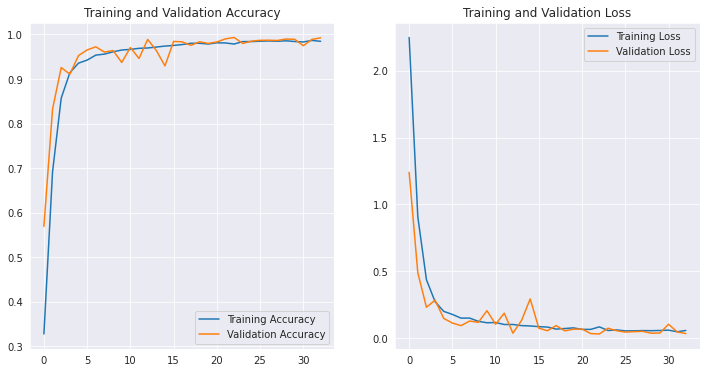

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### 4.4 Model Persistion

The following code saves the model to google drive.

In [ ]:
# save model
!mkdir -p drive/MyDrive/checkpoints
model.save_weights('drive/MyDrive/checkpoints/vgg16_model_acc_99_additional_pp_layers_weights')
model.save('drive/MyDrive/checkpoints/vgg16_model_acc_99_additional_pp_layers_model')

## 5 Evaluation

### 5.1 Classification Metrics

First, the metrics are evaluated on the testing set using TensorFlows built-in methods.

In [ ]:
model.evaluate(X_test, y_test)

1226/1226 [==============================] - 6s 5ms/step - loss: 0.0248 - accuracy: 0.9937


[0.024809163063764572, 0.9936749339103699]

Then, predictions are made for the full testing set, which enables a more thorough evaluation for more metrics with sklearn's classification report.

In [ ]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)

1226/1226 [==============================] - 4s 4ms/step


In [ ]:
print(classification_report(y_test, 
                            y_pred_classes, 
                            target_names=list(class_names.values()),
                            labels=list(class_names.keys())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.99      0.99      0.99       210
         Speed limit (30km/h)       1.00      0.98      0.99      2220
         Speed limit (50km/h)       0.99      0.99      0.99      2250
         Speed limit (60km/h)       0.99      0.99      0.99      1410
         Speed limit (70km/h)       0.98      1.00      0.99      1980
         Speed limit (80km/h)       0.98      1.00      0.99      1860
  End of speed limit (80km/h)       1.00      0.99      0.99       420
        Speed limit (100km/h)       1.00      0.99      1.00      1440
        Speed limit (120km/h)       1.00      0.99      1.00      1410
                   No passing       1.00      1.00      1.00      1470
 No passing veh over 3.5 tons       1.00      1.00      1.00      2010
 Right-of-way at intersection       1.00      1.00      1.00      1320
                Priority road       1.00      1.00      1.00      2100
     

### 5.2 Confusion Matrix

Based on the prediction, a confusion matrix can be created for later visualization. Because using all 40+ classes is not very beneficial, columns and rows including a value above a certain threshold (and excluding the diagonal, which contains the correctly classified examples) are determinded and can be used in the plots later.

In [ ]:
a = confusion_matrix(y_test, y_pred_classes, normalize='true')

diagonal = np.diag(a).copy()

# fill diagonal with zeros
np.fill_diagonal(a, False)

# columns with at least one non-zero
cols = a.any(axis=0)

# rows with at least one non-zero
rows = a.any(axis=1)

# filter columns and rows that have values above one threshold (percentage of values)
threshold = 0.01
rows_nb, col_nb = a.shape
rows_above_threshold = [col for col in range(col_nb) \
    if any([a[row][col] >= threshold for row in range(rows_nb)])]
columns_above_threshold = [row for row in range(rows_nb) \
    if any([a[row][col] >= threshold for col in range(col_nb)])]

threshold_labels = list(set(columns_above_threshold + rows_above_threshold))

np.fill_diagonal(a, diagonal)

a = pd.DataFrame(a, index=class_names.values(), columns=class_names.values())

Confusion Matrix for all examples:

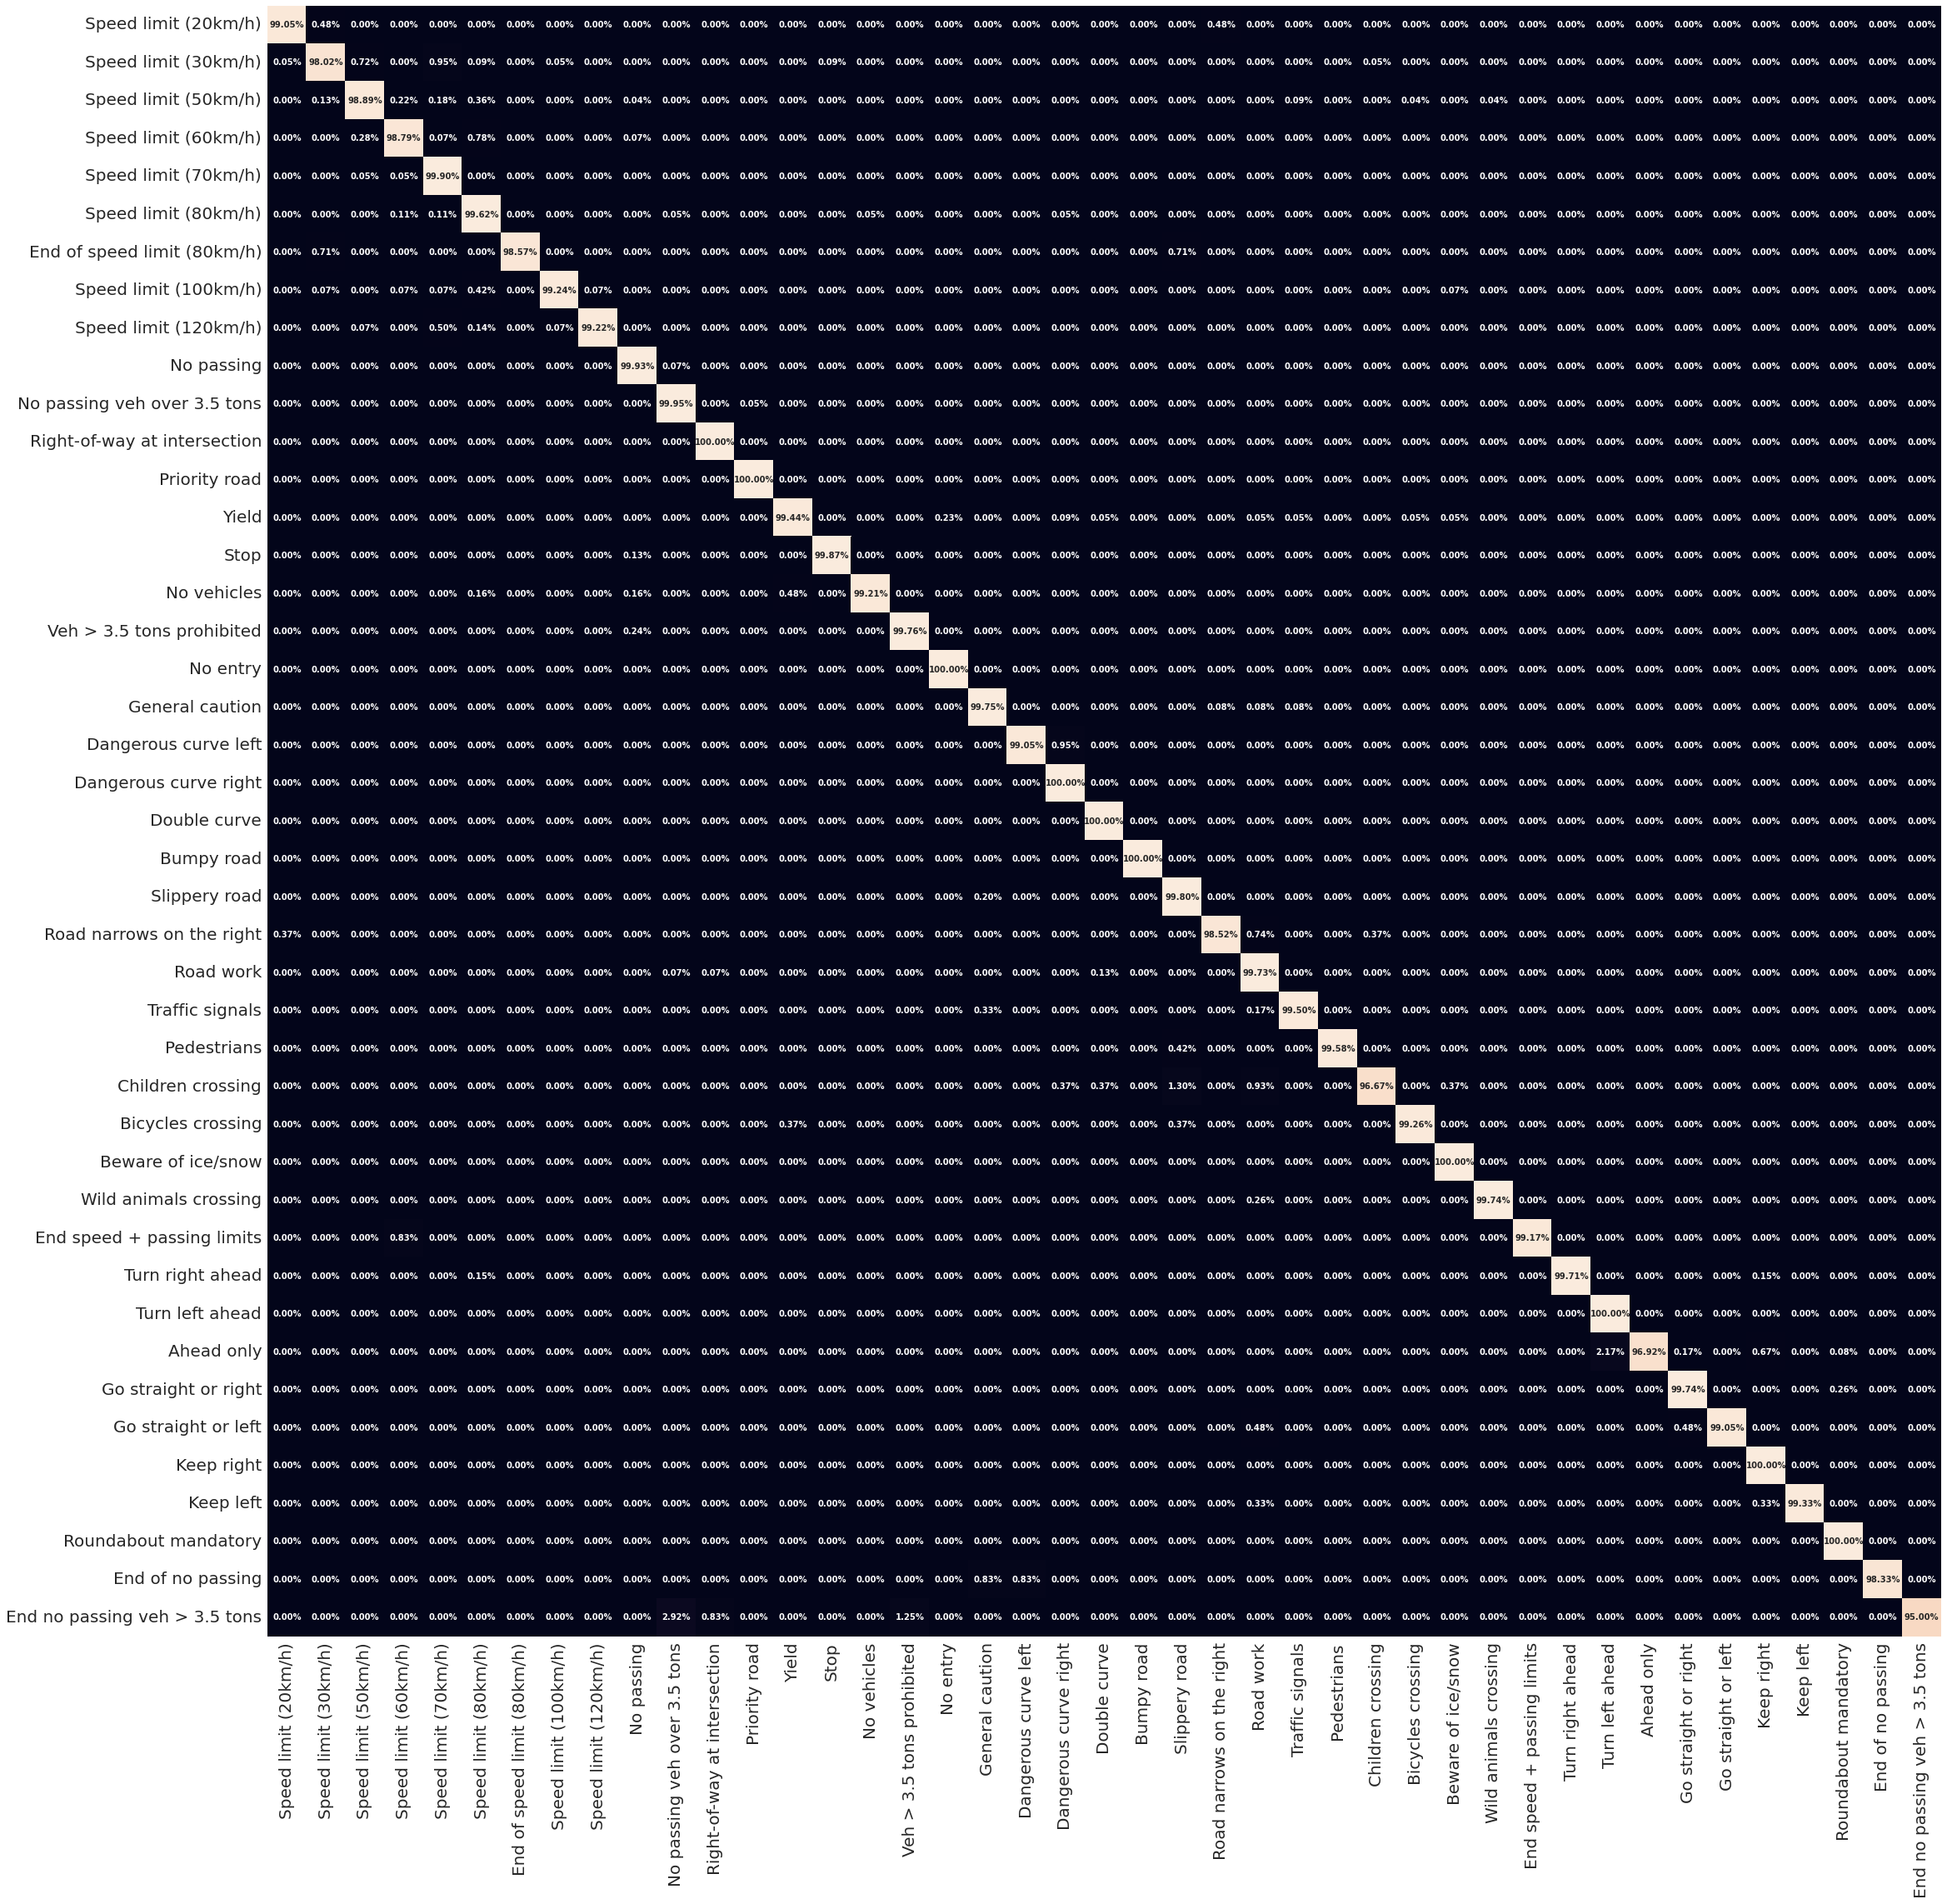

In [ ]:
fig, ax = plt.subplots(figsize=(36,36))
plot = sns.heatmap(a, annot=True, cbar=False, fmt='.2%', annot_kws={'weight': 'bold'})

plot.tick_params(labelsize=20)

Confusion Matrix for where more than the threshold of examples are predicted for a single, incorrect class.

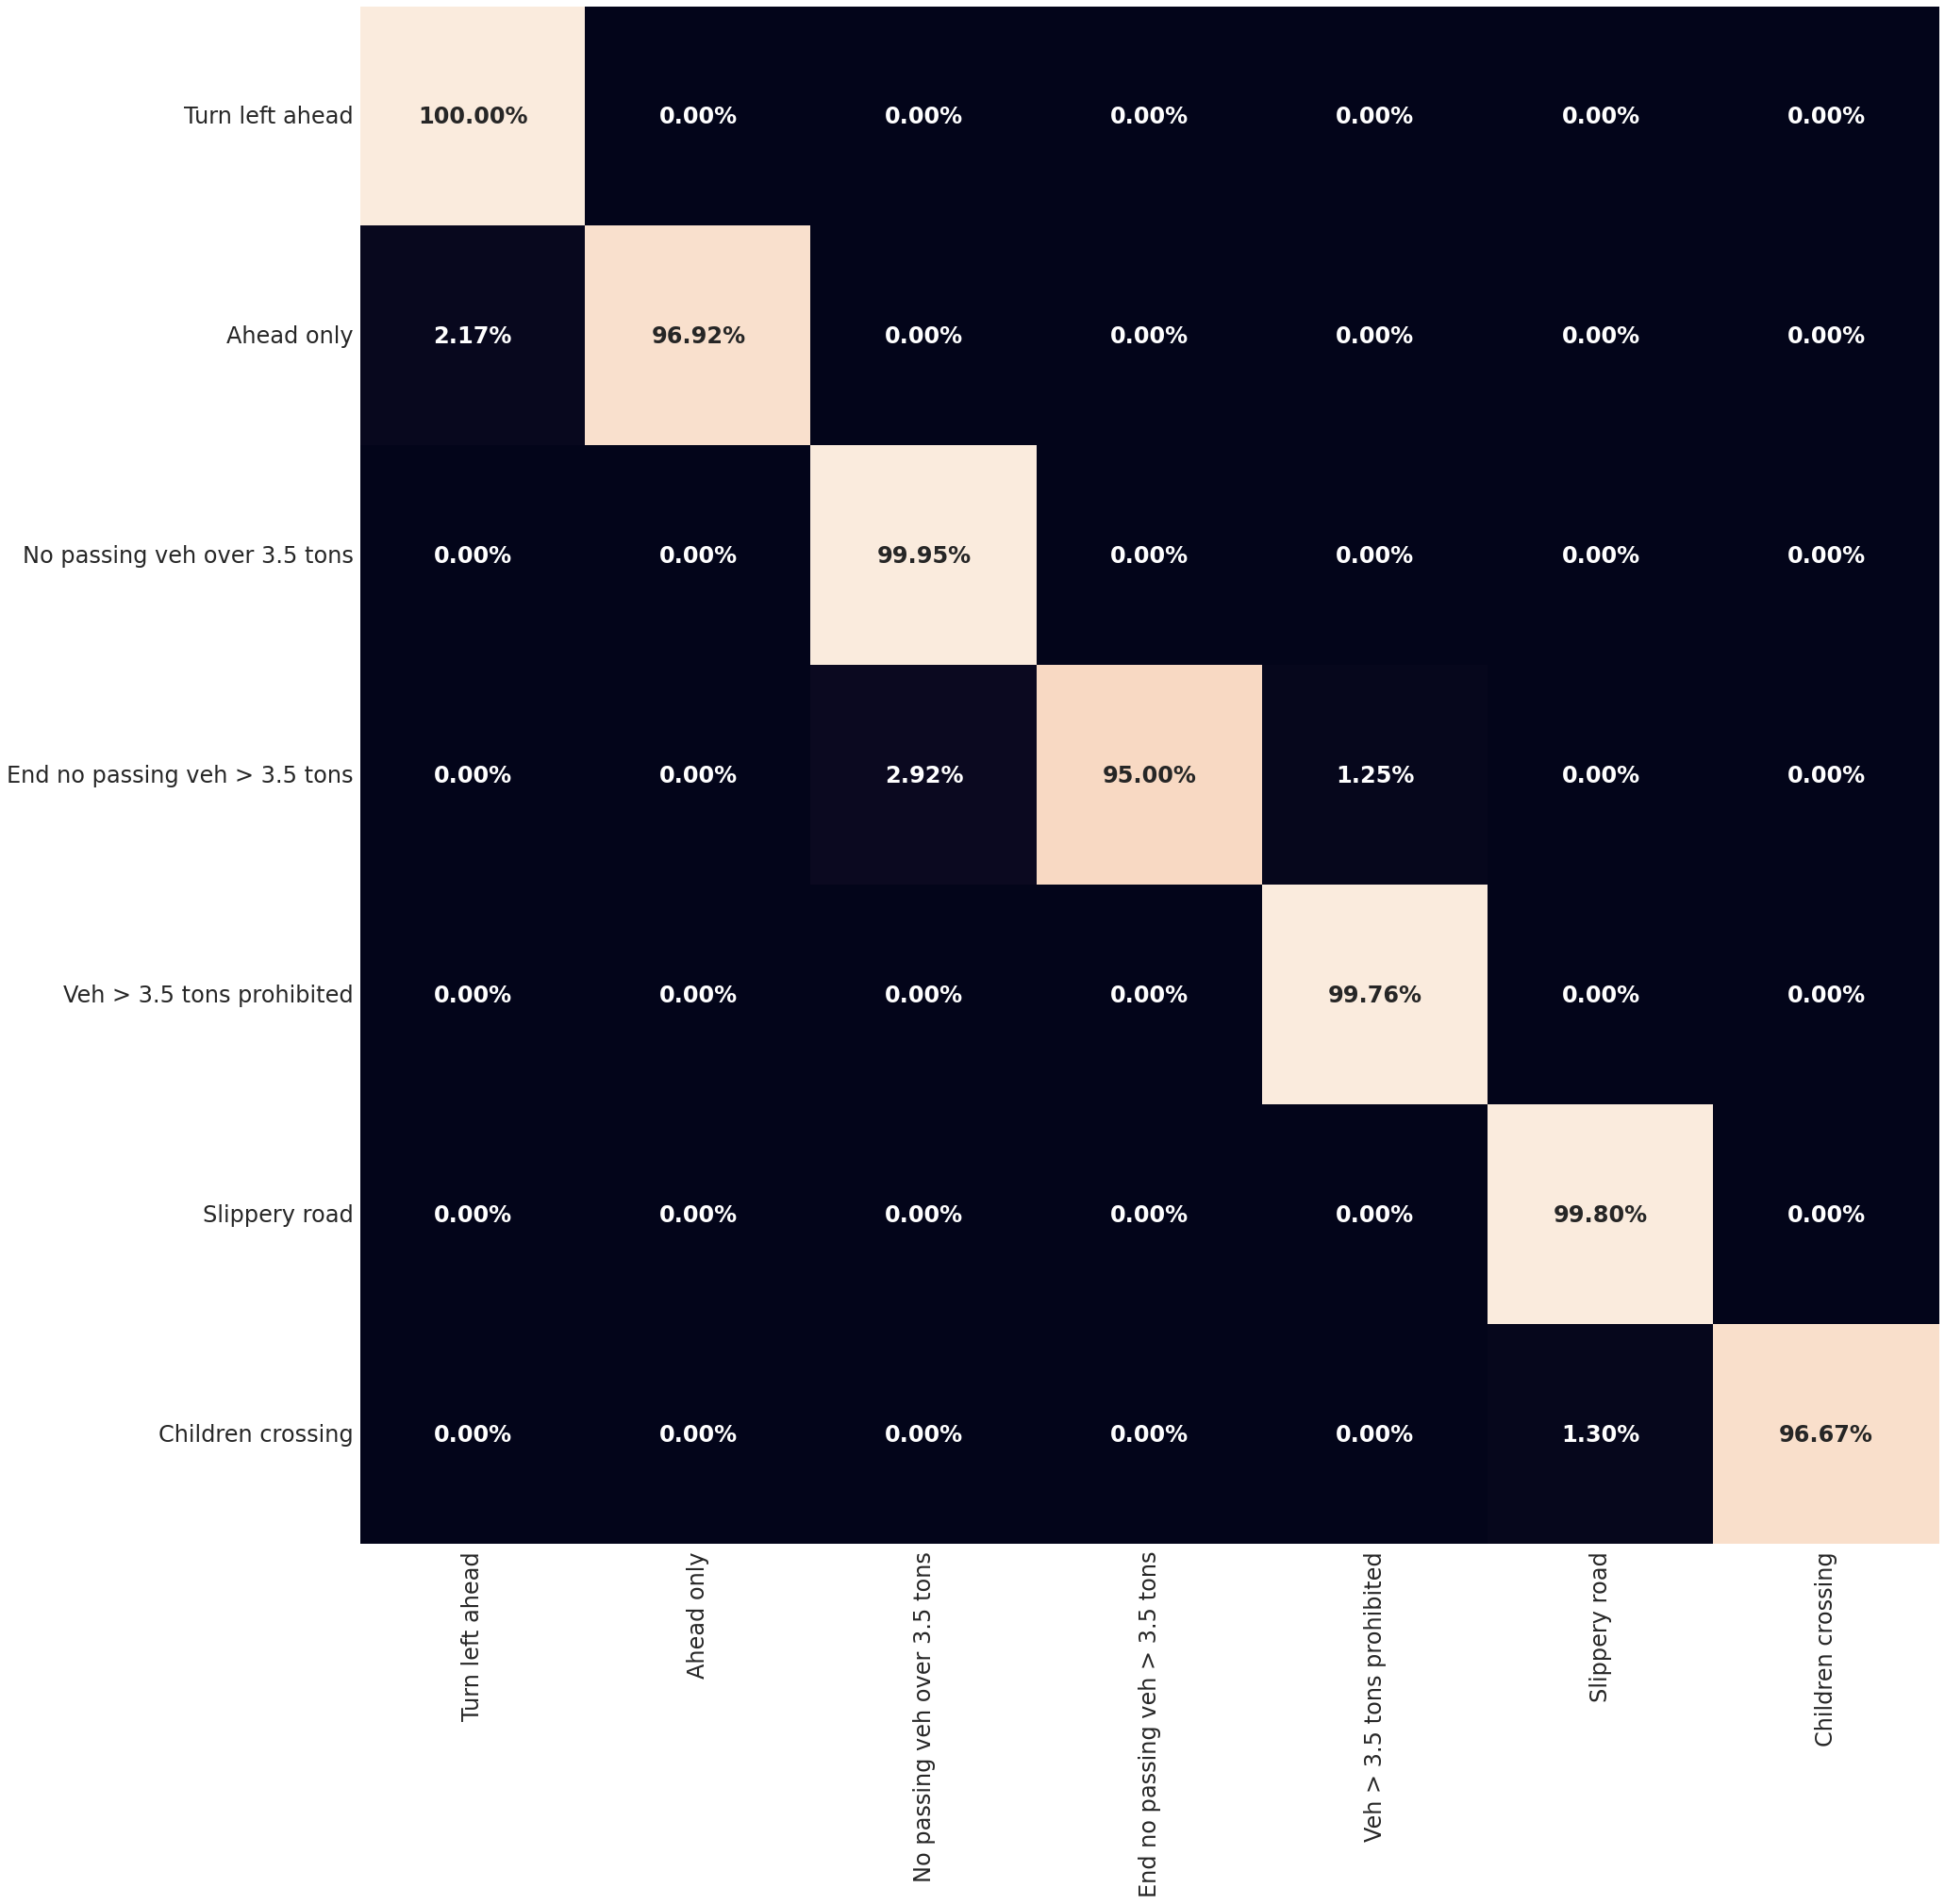

In [ ]:
if a.iloc[threshold_labels, threshold_labels].shape[0] > 0:
  fig, ax = plt.subplots(figsize=(30,30))

  plot = sns.heatmap(a.iloc[threshold_labels, threshold_labels], annot=True, cbar=False, fmt='.2%', annot_kws={'weight': 'bold', 'size': 24})

  plot.tick_params(labelsize=24)

  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 

  plt.show()
else:
  print(f'No entries in Confusion Matrix with number of misclassified examples above threshold of {threshold}')

### 5.3 Examples for Incorrect Predictions

Finally, some images that were incorrectly predicted are visualized to get a better impression of difficult samples.

In [ ]:
incorrectly_predicted_images = np.array([])
incorrectly_predicted_labels = np.array([])

for i in range(len(y_test)):
  if y_test[i] != y_pred_classes[i]:
     if len(incorrectly_predicted_images)!=0:
       incorrectly_predicted_images = np.append(incorrectly_predicted_images, X_test[i].reshape((-1, 30, 30, 3)), axis=0)
       incorrectly_predicted_labels = np.append(incorrectly_predicted_labels, y_pred_classes[i])
     else:
       incorrectly_predicted_images = X_test[i].reshape((-1, 30, 30, 3))
       incorrectly_predicted_labels = y_pred_classes[i]

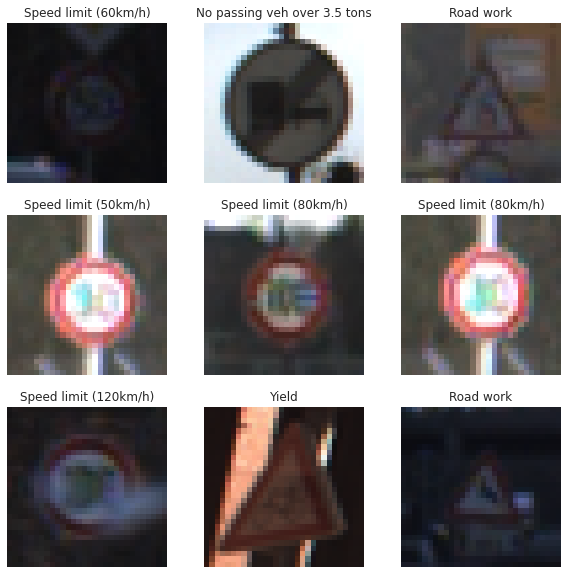

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Wrong predicted traffic signs")
for i in range(min(len(incorrectly_predicted_images), 9)):
    ax = plt.subplot((min(len(incorrectly_predicted_images), 9)-1)//3+1, 3, i + 1)
    plt.imshow(incorrectly_predicted_images[i].astype("uint8"))
    plt.title(class_names[incorrectly_predicted_labels[i]])
    plt.axis("off")